<a href="https://colab.research.google.com/github/rubencg195/Pytorch-Tutorials/blob/master/DeepQLearning_Pytorch_SpaceInvaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Deep%20Q%20Learning/Space%20Invaders/DQN%20Atari%20Space%20Invaders.ipynb

In [0]:
%matplotlib inline

import os
import time
import gym
import math
import random
import numpy as np

In [15]:
OS_Windows = False

if OS_Windows:
    !ECHO %CurrentDir%
    drive_path = "gdrive/My Drive/Colab Notebooks/"
else:
    #Install Google Drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    drive_path = "gdrive/My Drive/Colab Notebooks/"
    !ls  "gdrive/My Drive/Colab Notebooks/"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 Beginner					    KRAGGLE
 Books						    log_deepq_pytorch.txt
'Convolutionary Network Tutorial - Pytorch.ipynb'   model_deepq_pytorch.ckpt
'DATA LOADING AND PROCESSING TUTORIAL.ipynb'	    MUN
 DeepQLearning-Pytorch.ipynb			    PONG
'DeepQ Learning Tutorial.ipynb'			    PyTorch
'DEEPQ NETWORK SPACE INVADERS.ipynb'		    STATISTICS
 Intermidiate					    Theory
'Keras Tutorial'				    Udacity


In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#import torchvision.transforms as T
from torch.autograd import Variable

#Hyperparameters

In [18]:
#Environment
env_name = 'SpaceInvaders-v0' #@param ["DoomBasic-v0", "Breakout-v0", "Pong-v0"] {allow-input: true}

env = gym.make(env_name)

print("Action Space: ", env.action_space.n)
print("Action Space: ", env.observation_space.shape)

possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist()) 
print("Possible Actions: \n", possible_actions)


### MODEL HYPERPARAMETERS
frame_width  = 84                #@param {type:"number"} 
frame_height = 110               #@param {type:"number"} 

### PREPROCESSING HYPERPARAMETERS
# Number of frames stacked
stack_size = 4                   #@param {type:"number"}              
state_size = [frame_height, frame_width, stack_size]        # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels)

# 6 possible actions
##action_size = env.action_space.n   #@param {type:"raw"}
action_size = 6   #@param {type:"raw"}

# Alpha (aka learning rate)
learning_rate =  0.00025         #@param {type:"number"}      

### TRAINING HYPERPARAMETERS

# Total episodes for training
total_episodes = 2000              #@param {type:"number"}
# Max possible steps in an episode
max_steps = 50000                #@param {type:"number"} 
# Batch size
batch_size = 10                #@param {type:"number"}              

# Exploration parameters for epsilon greedy strategy

# exploration probability at start
explore_start = 1.0              #@param {type:"number"}
# minimum exploration probability 
explore_stop = 0.01              #@param {type:"number"}
# exponential decay rate for exploration prob
decay_rate = 0.00001             #@param {type:"number"}         

# Q learning hyperparameters
# Discounting rate
gamma = 0.9                      #@param {type:"number"}                

### MEMORY HYPERPARAMETERS

# Number of experiences stored in the Memory when initialized for the first time
pretrain_length = batch_size  
# Number of experiences the Memory can keep
memory_size = 1000000            #@param {type:"number"}       


### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False                 #@param ["False", "True"] {type:"raw"}

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False           #@param ["False", "True"] {type:"raw"}

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0]...]

# We stack 4 frames
stack_size = 4  #@param {type:"number"}       

target_update = 10 #@param {type:"number"}       


Action Space:  6
Action Space:  (210, 160, 3)
Possible Actions: 
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


#Preprocessing

**Stack frames**

As explained in this really good article we stack frames.

https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/

Stacking frames is really important because it helps us to give have a sense of motion to our Neural Network.

BUT, we don't stack each frames, we skip 4 frames at each timestep. This means that only every fourth frame is considered. And then, we use this frame to form the stack_frame.

The frame skipping method is already implemented in the library.

First we preprocess frame
Then we append the frame to the deque that automatically removes the oldest frame
Finally we build the stacked state
This is how work stack:

For the first frame, we feed 4 frames
At each timestep, we add the new frame to deque and then we stack them to form a new stacked frame
And so on stack
If we're done, we create a new stack with 4 new frames (because we are in a new episode).

In [0]:
from skimage import transform      # Help us to preprocess the frames
from skimage.color import rgb2gray # Help us to gray our frames
import matplotlib.pyplot as plt    # Display graphs
import warnings                    # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

def preprocess_frame(frame, display=False):
  """
  Reduce complexity
  Steps:
  1. Grayscale
  2. Crop
  3. Normalize 
  4. Resize
  """ 
  gray       = rgb2gray(frame)
  cropped    = gray[8:-12, 4:-12] 
  normalized = cropped/255.0 
  resized    = transform.resize(normalized, [110,84])
  
  if display: 

    fig, ax = plt.subplots(nrows=1, ncols=5, sharey=True, sharex=True, figsize=(25,50))

    plt.subplot(1, 5, 1)
    plt.imshow(frame)
    
    plt.subplot(1, 5, 2)
    plt.imshow(gray)
    
    plt.subplot(1, 5, 3)
    plt.imshow(cropped)
    
    plt.subplot(1, 5, 4)
    plt.imshow(normalized)
    
        
    plt.subplot(1, 5, 5)
    plt.imshow(resized)

    plt.show()
    
    #print("New  Shape: ", resized.shape)

  return resized # 110x84x1 frame
  
  
  

In [0]:
def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((110,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)
        
        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 

        #print("stacked_frames shape", len(stacked_frames), stacked_frames[0].shape )
        #print("stacked_state shape", stacked_state.shape)
        #Output 
        #stacked_frames shape 4 (110, 84)
        #stacked_state shape (110, 84, 4)
    
    return stacked_state, stacked_frames

Shape (210, 160, 3)


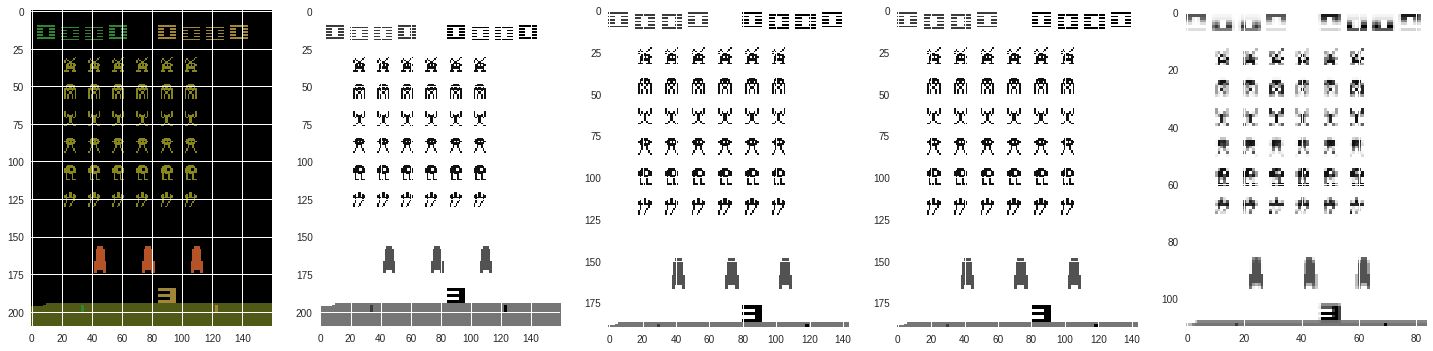

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00151918, 0.00151918, 0.00151918, ..., 0.00147554, 0.        ,
        0.        ],
       [0.00136726, 0.00136726, 0.00029298, ..., 0.00132799, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00115   , 0.00115   ,
        0.00115   ],
       [0.000805  , 0.000805  , 0.00116643, ..., 0.001265  , 0.001265  ,
        0.001265  ]])

In [21]:
obs = env.reset()
print("Shape",  obs.shape )
preprocess_frame(obs, display=True)

#Deep Q Network

In [22]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return (output)

#Input (3, 110, 84) Conv, Output specified = 18 for batch size. for Maxpool layer number 1 remains unchanged
print("Convolution #1", (32,
       outputSize(in_size=110, kernel_size=8, stride=4, padding=1 ),
       outputSize(in_size=84 , kernel_size=8, stride=4, padding=1 ),
      ))

#Input (32, 27, 20) Conv, Output specified = 18 for batch size. for Maxpool layer number 1 remains unchanged
print("Convolution #2", (64,
       outputSize(in_size=27 , kernel_size=4, stride=2, padding=0 ),
       outputSize(in_size=20 , kernel_size=4, stride=2, padding=0 ),
      ))

#Input (64, 12, 9) Conv, Output specified = 18 for batch size. for Maxpool layer number 1 remains unchanged
print("Convolution #3", (128,
       outputSize(in_size=12, kernel_size=3, stride=2, padding=0 ),
       outputSize(in_size=9 , kernel_size=3, stride=2, padding=0 ),
      ))


Convolution #1 (32, 27, 20)
Convolution #2 (64, 12, 9)
Convolution #3 (128, 5, 4)


In [0]:
class DeepQ(nn.Module):
  def __init__(self, learning_rate, num_actions, input_shape ):
    super(DeepQ, self).__init__()
    self.conv1  = nn.Conv2d(4,   32 , kernel_size=8, stride=4, padding=1 )
    self.bn1    = nn.BatchNorm2d(32)
    
    self.conv2  = nn.Conv2d(32,   64 , kernel_size=4, stride=2, padding=0 )
    self.bn2    = nn.BatchNorm2d(64)
    
    self.conv3  = nn.Conv2d(64,   128, kernel_size=3, stride=2, padding=0 )
    self.bn3    = nn.BatchNorm2d(128)
    
    self.fc1    = nn.Linear(128 * 5 * 4  , 512)
    self.fc2    = nn.Linear(512          , num_actions)
    
    self.optim  = optim.Adam(self.parameters(), lr=learning_rate)
    self.loss   = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)
    
  def forward(self, obs):
    #print("Forward Input Shape", obs.shape)
    obs     =obs.to(self.device)
    obs     = obs.view(-1, 4, 110, 84 )
    obs     = F.relu(self.bn1(self.conv1(obs)))
    obs     = F.relu(self.bn2(self.conv2(obs)))
    obs     = F.relu(self.bn3(self.conv3(obs)))
    obs     = obs.view(-1, 128 * 5 * 4 )
    obs     = F.relu(self.fc1(obs))
    
    actions = self.fc2(obs) #No Relu, raw data represents Q(s, a) value
    return actions
    

#Memory

In [0]:
from collections import deque# Ordered collection with ends
class Memory():
  def __init__(self, max_size):
    self.buffer = deque(maxlen = max_size)
    
  def add(self, experience):
    self.buffer.append(experience)
   
  def len(self):
    return len(self.buffer)
  
  def sample(self, batch_size):
#     print('Buffer Size', len(self.buffer) )
    return random.sample(self.buffer, batch_size)
#     buffer_size = len(self.buffer)
#     index       = np.random.choice(
#         np.arange(buffer_size), 
#         size    = batch_size,
#         replace = False 
#     )
#     return [self.buffer[i] for i in index]

#Agent

In [0]:
class Agent(object):
  def __init__(self, 
                  stack_size,
                  state_size,
                  action_size,
                  learning_rate,
                  total_episodes,
                  max_steps,
                  batch_size,
                  explore_start,
                  explore_stop,
                  decay_rate,
                  gamma,
                  pretrain_length,
                  memory_size,
                  training ,
                  episode_render,
                  possible_actions,
                  target_update
              ):
    
    self.stack_size         = stack_size
    self.state_size         = state_size
    self.action_size        = action_size
    self.learning_rate      = learning_rate
    self.total_episodes     = total_episodes
    self.max_steps          = max_steps
    self.batch_size         = batch_size
    self.explore_start      = explore_start
    self.explore_stop       = explore_stop
    self.decay_rate         = decay_rate
    self.gamma              = gamma
    self.pretrain_length    = pretrain_length
    self.memory_size        = memory_size
    self.training           = training
    self.episode_render     = episode_render
    self.possible_actions   = possible_actions
    self.target_update      = target_update
    self.Q_eval             = DeepQ(
        learning_rate       =  self.gamma
        ,num_actions        =  self.action_size
        ,input_shape        =  self.state_size
    )
    self.Q_target           = DeepQ(
        learning_rate       =  self.gamma,
        num_actions         =  self.action_size,
        input_shape         =  self.state_size
    )  
     
    print("Loadinig Models")
      
    self.Q_target.load_state_dict(
        T.load(
            drive_path+"/model_deepq_pytorch.ckpt", 
            map_location=self.Q_target.device
        )
    )  
    self.Q_target.load_state_dict(
        T.load(
            drive_path+"/model_deepq_pytorch.ckpt", 
            map_location=self.Q_target.device
        )
    )
    
    
    device = T.device("cuda" if T.cuda.is_available() else "cpu") # PyTorch v0.4.0
    self.Q_eval.to(device)
    self.Q_target.to(device)
    

    #Target Policy
    self.memory = Memory(max_size = self.memory_size)
    # Initialize deque with zero-images one array for each image
    self.stacked_frames  =  deque(
        [np.zeros((110,84), dtype=np.int) for i in range(stack_size)], 
        maxlen=4
    )

    
    print(
      '_'*10 +  'HYPERPARAMETERS'  +   '_'*10  + '\n'     ,
      '\nstack_size        '      ,self.stack_size        , 
      '\nstate_size        '      ,self.state_size        ,
      '\naction_size       '      ,self.action_size       ,
      '\nlearning_rate     '      ,self.learning_rate     ,
      '\ntotal_episodes    '      ,self.total_episodes    ,
      '\nmax_steps         '      ,self.max_steps         ,
      '\nbatch_size        '      ,self.batch_size        ,
      '\nexplore_start     '      ,self.explore_start     ,
      '\nexplore_stop      '      ,self.explore_stop      ,
      '\ndecay_rate        '      ,self.decay_rate        ,
      '\ngamma             '      ,self.gamma             ,
      '\npretrain_length   '      ,self.pretrain_length   ,
      '\nmemory_size       '      ,self.memory_size       ,
      '\ntraining          '      ,self.training          ,
      '\nepisode_render    '      ,self.episode_render    ,
      '\ntarget_update     '      ,self.target_update     ,
      '\npossible_actions\n'      ,self.possible_actions  ,
      '\n'
    )
  
  def save_log(self, episode,total_reward, explore_probability, loss, running_loss , time, step, exp, running, action ):
    with open(drive_path+"/log_deepq_pytorch.txt" , "a") as myfile:
      log = '{} Episode: {} Total reward: {} Explore P: {:.4f} nTraining RunningLoss {:.4f} Loss {:.4f} Time Lapse {} Min. Step: {} {} Action {}'.format( 
          running, episode,total_reward, explore_probability, running_loss , loss , time, step, exp, action
      ) 
      myfile.write(log)
      print(log)
      
  def predict_action(self, decay_step, state):
    #EPSILON GREEDY STRATEGY
    #Choose action a from state s using epsilon greedy
    #First we randomize a number
    exp_exp_tradeoff       = np.random.rand()
    explore_probability    = self.explore_stop         \
    + (self.explore_start  - self.explore_stop  )      \
    * np.exp(-decay_rate   * decay_step    )
    
    if(explore_probability > exp_exp_tradeoff):
      #Make a random action (Exploration)
      choice               = random.randint(1, len(self.possible_actions)) - 1
      action               = self.possible_actions[choice]

    else:
      #Get action from QNet (Explotation)
      action   =  self.Q_eval.forward(T.Tensor(state))
      action   =  T.argmax(action).item()
      
    return action, explore_probability, (explore_probability > exp_exp_tradeoff)
  
  def train(self):
    #Initialize the decay_rate (This will reduce epsilon)
    self.decay_step        = 0
    self.start_time        = time.time()
    
    self.state             = env.reset()
    preprocess_frame(self.state, display=True)
    
    self.reward_list       = []
    
    for episode in range(self.total_episodes):
      #Set Step to 0
      self.step            = 0
      

      #Initialize the rewards of the episode
      self.episode_rewards = []
      
      #Make a new episode and observe 
      self.state                  = env.reset()
      
      #Remember that stack frame function also call our preprocess function
      self.state, self.stacked_frames  = stack_frames(
          self.stacked_frames, 
          self.state, 
          is_new_episode=True
      )
      
      while self.step < self.max_steps:
        self.step       += 1
        
        #Increase the decay step
        self.decay_step += 1
        
        #Predict the action to take and take it
        self.action, self.explore_probability, self.exploration_vs_explotation = self.predict_action(
            self.decay_step,
            self.state
        )
        
        #Perform the action and get the next_state, reward, and done info
        self.next_state, self.reward, self.done, _ = env.step(np.argmax(self.action))
        
        if episode_render:
          env.render()
          
        #Add the reward to the total reward
        self.episode_rewards.append(self.reward)
        
        if self.done:
          #The episode ends so no next state
          self.next_state = np.zeros( (110, 84) , dtype=np.int )
          
          self.next_state, self.stacked_frames = stack_frames(
              self.stacked_frames, 
              self.next_state,
              is_new_episode=False
          )
          
          #Set Step = max_steps to end the episode
          self.step = self.max_steps
          
          #Get the total reward of the episode
          total_reward = np.sum(self.episode_rewards)
          
          self.save_log(
              episode,
              total_reward,
              self.explore_probability,
              self.loss.item() / self.step ,
              self.loss.item() , 
              ( time.time() - self.start_time) / 60,
              self.step,
              "Exploration"  if (self.exploration_vs_explotation) else "Explotation",
              "Done:",
              np.argmax(self.action)
          )
          
          self.reward_list.append( (episode, total_reward) )
          
          #Store transition <st,at,rt+1,st+1> in memoryD
          self.memory.add( 
              (self.state, self.action, self.reward, self.next_state, self.done)
          )
          
        else:
          #Stack the frame of the next_state
          self.next_state, stacked_frames = stack_frames(
            self.stacked_frames, 
            self.next_state,
            is_new_episode=False
          )
          
          #Add experence to memory
          self.memory.add( 
              (self.state, self.action, self.reward, self.next_state, self.done)
          )
          
          #st+1 is now our current state
          self.state = self.next_state
          
        ###LEARNING
        #obtain random mini-batch from memory
        if self.memory.len() > self.batch_size:
          
          batch              = self.memory.sample(self.batch_size)
          states_mb          = T.FloatTensor(np.array([each[0] for each in batch])).to(self.Q_eval.device)
          #actions_mb         = np.array([each[1] for each in batch])
          rewards_mb         = T.FloatTensor(np.array([each[2] for each in batch])).to(self.Q_eval.device)
          next_states_mb     = T.FloatTensor(np.array([each[3] for each in batch])).to(self.Q_eval.device)
          dones_mb           = np.array([each[4] for each in batch])

          target_Qs_batch    = []
          
          #Get Q values for next state
          self.Qs_next_state       = self.Q_target.forward(next_states_mb)
          self.Qs_state            = self.Q_eval.forward(states_mb)
          self.Qtarget             = T.zeros_like(self.Qs_next_state) 
         
          #Set Q_target = r if the episode ends at s+1, otherwise
          #set Q_target = r + gamma*maxQ(s', a')
          for i in range  (0, len(batch)):
            terminal = dones_mb[i]
            
            #if we are in a terminal state only equals reward
            if terminal:
              target = rewards_mb[i]
            else:
              target = rewards_mb[i] + gamma * T.max(self.Qs_next_state[i])
              
            target_Qs_batch.append(target)
            #shape (batch_size, num_actions) we want first dim
            #We want the loss function to be zero for every action except the maxAction
            maxAction                 = T.argmax(self.Qs_next_state[i]).to(self.Q_eval.device)
            self.Qtarget[i,maxAction] = target
            
    
          self.loss       = self.Q_eval.loss(
              self.Qtarget, 
              self.Qs_state
          ).to(self.Q_eval.device)
          # Optimize the model
          self.Q_eval.optim.zero_grad()
          self.loss.backward()
          self.Q_eval.optim.step()
         
          
          #Get the total reward of the episode
          total_reward = np.sum(self.episode_rewards)
          
          if(self.step % 500 == 0):
            self.save_log(
                episode,
                total_reward,
                self.explore_probability,
                self.loss.item() / 500 , 
                self.loss.item() , 
                ( time.time() - self.start_time) / 60,
                self.step,
                "Exploration"  if (self.exploration_vs_explotation) else "Explotation",
                "Running:",
                np.argmax(self.action)
            )
            
          
#           print(self.Qtarget.shape,  self.Qs_state.shape, self.batch_size, states_mb.shape )
#           return;

        
      # Save model every 5 episodes
      if episode % target_update == 0:
          T.save(self.Q_eval.state_dict(), drive_path+"/model_deepq_pytorch.ckpt" )
          self.Q_target.load_state_dict(self.Q_eval.state_dict())
          print("Saving Model and Updating Target")
          
          
  
  def play(self):
    state                  = env.reset()
    totalScore             = 0
    self.decay_step        = 0
    
    
    #Load the model
    filename   = "./models/model.ckpt" 
    if( os.path.isfile(filename) ):
      self.Q_eval.load_state_dict(torch.load(filename))
    
    #Make a new episode and observe 
    state                  = env.reset()

    #Remember that stach frame function also call our preprocess function
    state, stacked_frames  = stack_frames(stacked_frames, state, is_new_episode=True)
      
    for episode in range(10):
      
      self.step              = 0
      
      
      while self.step < self.max_steps:
        decay_step += 1
        step += 1

        #Predict the action to take and take it
        action, explore_probability = predict_action(
            decay_step,
            state
        )

        #Perform the action and get the next_state, reward, and done info
        next_state, reward, done, _ = env.step(action)

        if episode_render:
          env.render()

        if not done:
          next_state, stacked_frames = stack_frames(
            stacked_frames, 
            next_state,
            is_new_episode=False
          )

          #Add experence to memory
          memory.add( (state, action, reward, next_state, done) )

          #st+1 is now our current state
          state = next_state
    

#Train

Loadinig Models
__________HYPERPARAMETERS__________
 
stack_size         4 
state_size         [110, 84, 4] 
action_size        6 
learning_rate      0.00025 
total_episodes     2000 
max_steps          50000 
batch_size         10 
explore_start      1.0 
explore_stop       0.01 
decay_rate         1e-05 
gamma              0.9 
pretrain_length    10 
memory_size        1000000 
training           False 
episode_render     False 
target_update      10 
possible_actions
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]] 



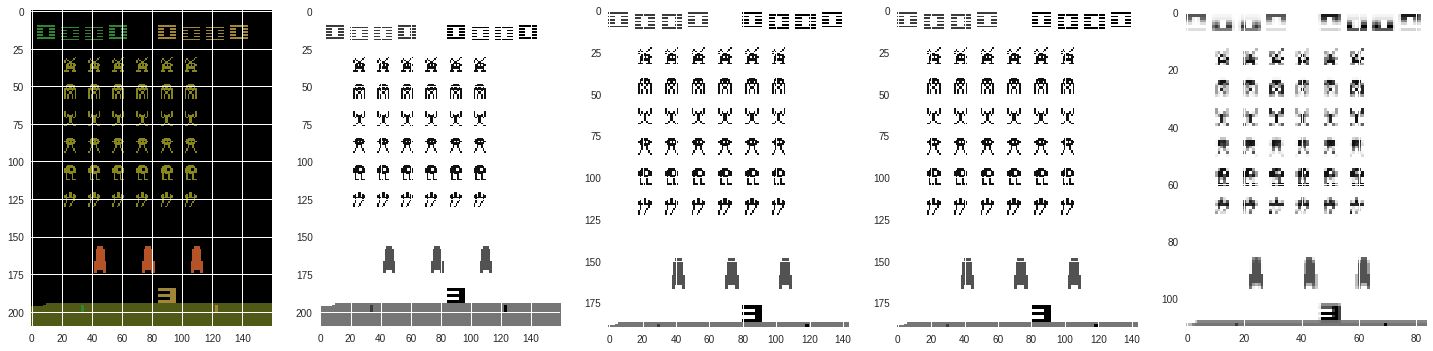

Running: Episode: 0 Total reward: 120.0 Explore P: 0.9951 nTraining RunningLoss 847.6860 Loss 1.6954 Time Lapse 0.3394514600435893 Min. Step: 500 Exploration Action 4
Done: Episode: 0 Total reward: 195.0 Explore P: 0.9912 nTraining RunningLoss 646.9156 Loss 0.0129 Time Lapse 0.5941988110542298 Min. Step: 50000 Exploration Action 0
Running: Episode: 0 Total reward: 195.0 Explore P: 0.9912 nTraining RunningLoss 646.3816 Loss 1.2928 Time Lapse 0.5949719031651814 Min. Step: 50000 Exploration Action 0
Saving Model and Updating Target
Running: Episode: 1 Total reward: 50.0 Explore P: 0.9863 nTraining RunningLoss 278.7762 Loss 0.5576 Time Lapse 0.9218075116475423 Min. Step: 500 Exploration Action 1
Done: Episode: 1 Total reward: 110.0 Explore P: 0.9847 nTraining RunningLoss 235.8268 Loss 0.0047 Time Lapse 1.0287882367769876 Min. Step: 50000 Exploration Action 3
Running: Episode: 1 Total reward: 110.0 Explore P: 0.9847 nTraining RunningLoss 235.5268 Loss 0.4711 Time Lapse 1.0294092496236165 Mi

In [0]:
agent = Agent(  
    stack_size       = stack_size,
    state_size       = state_size,
    action_size      = action_size,
    learning_rate    = learning_rate,
    total_episodes   = total_episodes,
    max_steps        = max_steps,
    batch_size       = batch_size,
    explore_start    = explore_start,
    explore_stop     = explore_stop,
    decay_rate       = decay_rate,
    gamma            = gamma,
    pretrain_length  = pretrain_length,
    memory_size      = memory_size,
    training         = training, 
    episode_render   = episode_render,
    possible_actions = possible_actions,
    target_update    = target_update
)
agent.train()
#agent.play()
# obs = env.reset()
# state, stacked_frames  = stack_frames(stacked_frames, obs, is_new_episode=True)
# agent.predict_action(0, state)